In [1]:
import os, tarfile, math
import pyBigWig
import pybedtools
import zipfile, gzip
from gtfparse import read_gtf
import pandas as pd
pd.set_option('display.max_columns', None)
from Bio import SeqIO
import pandas as pd
import numpy as np
import re 
from collections import Counter
from itertools import product
from collections import Counter

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
gtf_file_path = "/data/projects/Resources/Gencode_genome_annotation/gencode.v40.annotation.gtf"

In [3]:
def parse_attributes(attribute_string):
    # Split each attribute into key and value, then strip quotes and spaces
    return dict(item.strip().replace('"', '').split(' ') for item in attribute_string if item)

In [4]:
column_names = [
    "seqname", "source", "feature", "start", "end",
    "score", "strand", "frame", "attribute"
]

# Read the GTF file
gtf_df = pd.read_csv(gtf_file_path, sep="\t", comment='#', header=None, names=column_names)

In [5]:
# Step 1: Split the 'attribute' string into a list of strings for each key-value pair
attributes_list = gtf_df['attribute'].str.split(';')


# Apply the function to each row's attribute list
attributes_dicts = attributes_list.apply(parse_attributes)

# Step 3: Convert the list of dictionaries into a DataFrame
attributes_df = pd.DataFrame(list(attributes_dicts))

# Step 4: Combine the new attributes DataFrame with the original gtf_df
# This step assumes that the indexes are aligned and can be directly concatenated
combined_df = pd.concat([gtf_df, attributes_df], axis=1)

# Optionally, you can drop the original 'attribute' column if it's no longer needed
combined_df = combined_df.drop('attribute', axis=1)

In [6]:
combined_df

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
0,chr1,HAVANA,gene,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
2,chr1,HAVANA,exon,11869,12227,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,1,ENSE00002234944.1,NaN,NaN,NaN
3,chr1,HAVANA,exon,12613,12721,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,2,ENSE00003582793.1,NaN,NaN,NaN
4,chr1,HAVANA,exon,13221,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,3,ENSE00002312635.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283857,chrM,ENSEMBL,transcript,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
3283858,chrM,ENSEMBL,exon,15888,15953,.,+,.,ENSG00000210195.2,Mt_tRNA,MT-TT,3,HGNC:7499,NaN,ENST00000387460.2,Mt_tRNA,MT-TT-201,NA,Ensembl_canonical,NaN,1,ENSE00001544475.2,NaN,NaN,NaN
3283859,chrM,ENSEMBL,gene,15956,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,MT-TP,3,HGNC:7494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283860,chrM,ENSEMBL,transcript,15956,16023,.,-,.,ENSG00000210196.2,Mt_tRNA,MT-TP,3,HGNC:7494,NaN,ENST00000387461.2,Mt_tRNA,MT-TP-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Filter rows where 'feature' is 'transcript' and 'seqname' is not 'chrM'
gtf_transcript = combined_df[(combined_df["feature"] == "transcript") & (combined_df["seqname"] != "chrM")]

# Display the resulting DataFrame
gtf_transcript

,seqname,source,feature,start,end,score,strand,frame,gene_id,gene_type,gene_name,level,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,1,basic,OTTHUMT00000362751.1,NaN,NaN,NaN,NaN,NaN
5,chr1,HAVANA,transcript,12010,13670,.,+,.,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,2,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,NA,Ensembl_canonical,OTTHUMT00000002844.2,NaN,NaN,PGO:0000019,NaN,NaN
13,chr1,HAVANA,transcript,14404,29570,.,-,.,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,2,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,NA,Ensembl_canonical,OTTHUMT00000002839.1,NaN,NaN,PGO:0000005,NaN,NaN
26,chr1,ENSEMBL,transcript,17369,17436,.,-,.,ENSG00000278267.1,miRNA,MIR6859-1,3,HGNC:50039,NaN,ENST00000619216.1,miRNA,MIR6859-1-201,NA,Ensembl_canonical,NaN,NaN,NaN,NaN,NaN,NaN
29,chr1,HAVANA,transcript,29554,31097,.,+,.,ENSG00000243485.5,lncRNA,MIR1302-2HG,2,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,5,Ensembl_canonical,OTTHUMT00000002840.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283698,chrY,HAVANA,transcript,57209306,57210051,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,1,PAR,OTTHUMT00000058833.1,NaN,NaN,NaN,NaN,NaN
3283701,chrY,HAVANA,transcript,57209887,57212186,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,2,PAR,OTTHUMT00000058827.1,NaN,NaN,NaN,NaN,NaN
3283704,chrY,HAVANA,transcript,57210344,57212074,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211,1,PAR,OTTHUMT00000058834.1,NaN,NaN,NaN,NaN,NaN
3283708,chrY,HAVANA,transcript,57210591,57212074,.,+,.,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,2,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,2,PAR,OTTHUMT00000058835.1,NaN,NaN,NaN,NaN,NaN


In [9]:
gtf_transcript.groupby('transcript_type').size()

transcript_type
IG_C_gene                                23
IG_C_pseudogene                           9
IG_D_gene                                37
IG_J_gene                                18
IG_J_pseudogene                           3
IG_V_gene                               145
IG_V_pseudogene                         187
IG_pseudogene                             1
TEC                                    1147
TR_C_gene                                 6
TR_D_gene                                 4
TR_J_gene                                79
TR_J_pseudogene                           4
TR_V_gene                               106
TR_V_pseudogene                          33
lncRNA                                51324
miRNA                                  1879
misc_RNA                               2212
non_stop_decay                           99
nonsense_mediated_decay               20254
polymorphic_pseudogene                   71
processed_pseudogene                  10156
processed_transc

In [10]:
def extract_tss_regions_from_df(tss_df):
    """
    Extracts TSS (+50 and -50 bp) regions from the GTF DataFrame.
    :param df: A pandas DataFrame containing GTF data.
    :return: A DataFrame with TSS regions.
    """

    # Calculate TSS based on strand
    tss_df['TSS'] = tss_df.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)

    # Adjust TSS based on strand for +50 and -50 bp
    tss_df['start_adj'] = tss_df.apply(lambda x: x['TSS'] - 45 if x['strand'] == '+' else x['TSS'], axis=1)
    tss_df['end_adj'] = tss_df.apply(lambda x: x['TSS'] + 45 if x['strand'] == '+' else x['TSS'] + 90, axis=1)

    # Select and rename relevant columns
    tss_regions = tss_df[['seqname', 'TSS','start_adj', 'end_adj', 'strand', 'gene_id', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name']]
    tss_regions.columns = ['Chromosome', 'TSS', '45BP_Start', '50BP_End', 'Strand', 'GeneID', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name']

    return tss_regions

In [ ]:
tss_regions_df = extract_tss_regions_from_df(gtf_transcript)

/tmp/ipykernel_3751599/2696408818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_df['TSS'] = tss_df.apply(lambda x: x['start'] if x['strand'] == '+' else x['end'], axis=1)
/tmp/ipykernel_3751599/2696408818.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_df['start_adj'] = tss_df.apply(lambda x: x['TSS'] - 45 if x['strand'] == '+' else x['TSS'], axis=1)


In [ ]:
tss_regions_df

In [11]:
# Define a custom aggregation function
def custom_agg(series):
    # If all values are the same, return any one of them; otherwise, return the list of unique values
    if series.nunique() == 1:
        return series.iloc[0]
    else:
        return list(series.unique())

In [13]:
# Group by the columns 'Chromosome', 'Start', 'End', 'Strand'
# and aggregate other columns
unique_tss_df = tss_regions_df.groupby(['Chromosome', '50BP_Start', '50BP_End', 'Strand']).agg(custom_agg).reset_index()

In [14]:
unique_tss_df

,Chromosome,50BP_Start,50BP_End,Strand,TSS,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name
0,chr1,11819,11919,+,11869,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202
1,chr1,11960,12060,+,12010,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201
2,chr1,17436,17536,-,17436,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,[nan],ENST00000619216.1,miRNA,MIR6859-1-201
3,chr1,29504,29604,+,29554,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202
4,chr1,29570,29670,-,29570,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215293,chrY,57209256,57209356,+,57209306,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210
215294,chrY,57209837,57209937,+,57209887,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215
215295,chrY,57210294,57210394,+,57210344,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211
215296,chrY,57210541,57210641,+,57210591,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205


In [33]:
def read_genome(fasta_file):
    """
    Reads a genome fasta file and returns a dictionary of chromosomes and sequences.
    :param fasta_file: Path to the genome fasta file.
    :return: A dictionary with chromosome names as keys and sequences as values.
    """
    genome = {}
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        genome[seq_record.id] = seq_record.seq
    return genome

def fetch_sequences_for_regions(df, genome):
    """
    Fetches sequences for regions specified in the DataFrame from the genome.
    :param df: DataFrame with the regions (must contain 'Chromosome', 'Start', 'End', and 'Strand' columns).
    :param genome: Dictionary of genome sequences.
    :return: List of sequences corresponding to the regions.
    """
    sequences = []
    for index, row in df.iterrows():
        # Extracting the sequence
        seq = genome[row['Chromosome']][row['50BP_Start']:row['50BP_End']]
        
        # Reverse complement if the gene is on the negative strand
        if row['Strand'] == '-':
            seq = seq.reverse_complement()
        seq= seq.upper()
        
        sequences.append(str(seq))  # Converts Seq object to string
    return sequences

In [34]:
# Paths
genome_path = "/data/projects/Resources/Gencode_genome_annotation/GRCh38.primary_assembly.genome.fa"
# Load the genome and TSS regions
genome = read_genome(genome_path)
# Fetch sequences
sequences = fetch_sequences_for_regions(unique_tss_df, genome)

In [35]:
unique_tss_df['Sequence'] = sequences  # Add sequences to the DataFrame
unique_tss_df

,Chromosome,50BP_Start,50BP_End,Strand,TSS,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence
0,chr1,11819,11919,+,11869,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,GTTTAAACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTT...
1,chr1,11960,12060,+,12010,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,GGGCCTTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTG...
2,chr1,17436,17536,-,17436,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,[nan],ENST00000619216.1,miRNA,MIR6859-1-201,ATCAGACACAGGTACAGCACATAGGCCAGGAGCCAGGGGGTGACGG...
3,chr1,29504,29604,+,29554,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,CGAGTCGCGGGCCTGGGCACGGAACTCACGCTCACTCCGAGCTCCC...
4,chr1,29570,29670,-,29570,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,GAGGGGAAGGCAGCGATGGGACAAAGGACGGAGGTCTAGGAAGAGG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215293,chrY,57209256,57209356,+,57209306,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,CTGTAACAAAGACCCATGTGATGCTGGGGGCAGAGACAGAGGAGAA...
215294,chrY,57209837,57209937,+,57209887,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,ACTAACACCACCCCCACCGCCCCCACCACCACCCCCAGCTCCTGAG...
215295,chrY,57210294,57210394,+,57210344,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211,CAGTGTAACCCTAGCATCCAGAAGTGGCACAAAACCCCTCTGCTGG...
215296,chrY,57210541,57210641,+,57210591,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,TGACTTCCCTCCCAGCAGGCTCTTGGACACAGTAAGCTTCCCCAGC...


## PWM(Position weight matrix) generation

In [76]:
TATA_PFM_file_path = '/home/campus.stonybrook.edu/pdutta/Github/Postdoc/DNABERT_data_processing/Core_promoter/POL012.1.pfm'

## Creating Position Frequency Matrix(PFM)

In [78]:
# Parsing the PFM data from the text file
pfm = {}
nucleotides = ['A', 'C', 'G', 'T']

with open(TATA_PFM_file_path, 'r') as file:
    pfm_data = file.readlines()[1:]  # Skip the first line (header)

for line in pfm_data:
    parts = line.split()
    nt = parts[0]
    counts = [float(count) for count in parts[1:]]

    if nt in nucleotides:
        for i, count in enumerate(counts):
            if i not in pfm:
                pfm[i] = {}
            pfm[i][nt] = count

In [82]:
pfm

{0: {'A': 61.0, 'C': 145.0, 'G': 152.0, 'T': 31.0},
 1: {'A': 16.0, 'C': 46.0, 'G': 18.0, 'T': 309.0},
 2: {'A': 352.0, 'C': 0.0, 'G': 2.0, 'T': 35.0},
 3: {'A': 3.0, 'C': 10.0, 'G': 2.0, 'T': 374.0},
 4: {'A': 354.0, 'C': 0.0, 'G': 5.0, 'T': 30.0},
 5: {'A': 268.0, 'C': 0.0, 'G': 0.0, 'T': 121.0},
 6: {'A': 360.0, 'C': 3.0, 'G': 10.0, 'T': 6.0},
 7: {'A': 222.0, 'C': 2.0, 'G': 44.0, 'T': 121.0},
 8: {'A': 155.0, 'C': 44.0, 'G': 157.0, 'T': 33.0},
 9: {'A': 56.0, 'C': 135.0, 'G': 150.0, 'T': 48.0},
 10: {'A': 83.0, 'C': 147.0, 'G': 128.0, 'T': 31.0},
 11: {'A': 82.0, 'C': 127.0, 'G': 128.0, 'T': 52.0},
 12: {'A': 82.0, 'C': 118.0, 'G': 128.0, 'T': 61.0},
 13: {'A': 68.0, 'C': 107.0, 'G': 139.0, 'T': 75.0},
 14: {'A': 77.0, 'C': 101.0, 'G': 140.0, 'T': 71.0}}

## Creating Position Weight Matrix(PWM)

In [81]:
# Background nucleotide probabilities (assuming equal distribution)
background = {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}

# Convert PFM to probabilities and then to PWM (log-likelihood ratios)
pwm = {}
for pos, counts in pfm.items():
    #print(pos, counts)
    total_counts = sum(counts.values())
    #print(total_counts)
    pwm[pos] = {}
    for nt, count in counts.items():
        #print(nt, count)
        probability = (count+ (math.sqrt(total_counts)/4)) / (total_counts+math.sqrt(total_counts))
        #print(probability, background[nt])
        pwm[pos][nt] = np.log2(probability / background[nt])

In [86]:
pwm_df = pd.DataFrame.from_dict(pwm).reset_index(drop=False)
#pwm_df.reset_index(inplace=True)
pwm_df

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,A,-0.632100,-2.287426,1.804521,-3.687519,1.812582,1.417411,1.872907,1.151129,0.646324,-0.745881,-0.216684,-0.233185,-0.233185,-0.486524,-0.318646
1,C,0.553173,-1.004514,-4.373167,-2.774763,-4.373167,-4.373167,-3.662510,-3.881964,-1.062310,0.453590,0.572290,0.368657,0.266722,0.131483,0.051998
2,G,0.619005,-2.155767,-3.881964,-3.881964,-3.363074,-4.373167,-2.744280,-1.062310,0.664253,0.600500,0.379551,0.379551,0.379551,0.494251,0.504240
3,T,-1.507832,1.619323,-1.355551,1.890811,-1.548553,0.301507,-3.196441,0.301507,-1.429683,-0.948945,-1.507832,-0.843843,-0.632100,-0.354301,-0.428367


In [38]:
# Define all possible nucleotides for the variable positions
nucleotides = ['A', 'T']

# Generate all possible sequences for "TATA[AT][AT][AT]?"
#sequences_tata = ['TATA' + ''.join(p) for i in range(4) for p in product(nucleotides, repeat=i)]
# Correctly generating sequences for "TATA[AT][AT][AT]?"
# Start with "TATA", then add two mandatory [AT] and one optional [AT]
sequences_tata = ['TATA' + ''.join(p) for p in product(nucleotides, repeat=2)]  # Mandatory parts
sequences_tata += ['TATA' + ''.join(p) + q for p in product(nucleotides, repeat=2) for q in nucleotides]  # With optional part

print(sequences_tata)

# Generate all possible sequences for "[AT]?[AT][AT]TATA"
#sequences_at_tata = [''.join(p) + 'TATA' for i in range(3) for p in product(nucleotides, repeat=i)]
# It should start with an optional [AT], then two mandatory [AT], and end with "TATA"
sequences_at_tata = [''.join(p) + 'TATA' for p in product(nucleotides, repeat=2)]  # Mandatory parts
sequences_at_tata += [q + ''.join(p) + 'TATA' for p in product(nucleotides, repeat=2) for q in nucleotides]  # With optional part at start
print(sequences_at_tata)

# Combine all sequences
all_sequences = set(sequences_tata + sequences_at_tata)

# Count nucleotides at each position
nucleotide_counts = {i: Counter() for i in range(max(map(len, all_sequences)))}
print(nucleotide_counts)
for seq in all_sequences:
    for i, nucleotide in enumerate(seq):
        nucleotide_counts[i][nucleotide] += 1
print(nucleotide_counts)
# Convert counts to frequencies
pwm = {position: {nt: count/len(all_sequences) for nt, count in counts.items()} 
                          for position, counts in nucleotide_counts.items()}

pwm

['TATAAA', 'TATAAT', 'TATATA', 'TATATT', 'TATAAAA', 'TATAAAT', 'TATAATA', 'TATAATT', 'TATATAA', 'TATATAT', 'TATATTA', 'TATATTT']
['AATATA', 'ATTATA', 'TATATA', 'TTTATA', 'AAATATA', 'TAATATA', 'AATTATA', 'TATTATA', 'ATATATA', 'TTATATA', 'ATTTATA', 'TTTTATA']
{0: Counter(), 1: Counter(), 2: Counter(), 3: Counter(), 4: Counter(), 5: Counter(), 6: Counter()}
{0: Counter({'T': 17, 'A': 6}), 1: Counter({'A': 17, 'T': 6}), 2: Counter({'T': 19, 'A': 4}), 3: Counter({'A': 15, 'T': 8}), 4: Counter({'A': 14, 'T': 9}), 5: Counter({'T': 14, 'A': 9}), 6: Counter({'A': 12, 'T': 4})}


{0: {'A': 0.2608695652173913, 'T': 0.7391304347826086},
 1: {'A': 0.7391304347826086, 'T': 0.2608695652173913},
 2: {'T': 0.8260869565217391, 'A': 0.17391304347826086},
 3: {'T': 0.34782608695652173, 'A': 0.6521739130434783},
 4: {'A': 0.6086956521739131, 'T': 0.391304347826087},
 5: {'T': 0.6086956521739131, 'A': 0.391304347826087},
 6: {'A': 0.5217391304347826, 'T': 0.17391304347826086}}

In [73]:
def calculate_pwm_score(segment, pwm):
    score = 0
    for i, nucleotide in enumerate(segment):
        print(i, nucleotide, np.log(pwm[i].get(nucleotide, 1e-6)))
        score += np.log(pwm[i].get(nucleotide, 1e-6))  # Adding a small pseudocount for undefined cases
    return score

In [74]:
def find_tata_with_pwm(sequence, pwm, start_range, end_range):
    best_score = -np.inf  # Initialize with a very low score
    print(sequence)
    best_position = None
    for i in range(start_range, end_range + 1 - len(pwm)):  # Adjust range for segment length
        segment = sequence[i:i + len(pwm)]
        #print(segment, "DF")
        score = calculate_pwm_score(segment, pwm)
        if score > best_score:
            best_score = score
            best_position = i
        print(best_score, best_position)
        input()
    return best_score, best_position

In [75]:
# Apply the function to each sequence in the dataframe
unique_tss_df['PWM_Score'], unique_tss_df['PWM_Position'] = zip(*unique_tss_df['Sequence'].apply(
    lambda seq: find_tata_with_pwm(seq, pwm, 20, 35)))

GTTTAAACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTTTTCGTTAACTTGCCGTCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCATGTGTA
0 A -1.3437347467010947
1 C -13.815510557964274
2 C -13.815510557964274
3 G -13.815510557964274
4 G -13.815510557964274
5 G -13.815510557964274
6 T -1.749199854809259
-72.17048739133173 20


0 C -13.815510557964274
1 C -13.815510557964274
2 G -13.815510557964274
3 G -13.815510557964274
4 G -13.815510557964274
5 T -0.496436886313891
6 A -0.6505875661411494
-70.22457724227641 21


KeyboardInterrupt: Interrupted by user

In [62]:
unique_tss_df

,Chromosome,50BP_Start,50BP_End,Strand,TSS,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence,PWM_Score,PWM_Position
0,chr1,11819,11919,+,11869,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000456328.2,processed_transcript,DDX11L1-202,GTTTAAACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTT...,-17.353201,26
1,chr1,11960,12060,+,12010,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,HGNC:37102,OTTHUMG00000000961.2,ENST00000450305.2,transcribed_unprocessed_pseudogene,DDX11L1-201,GGGCCTTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTG...,-31.867879,22
2,chr1,17436,17536,-,17436,ENSG00000278267.1,miRNA,MIR6859-1,HGNC:50039,[nan],ENST00000619216.1,miRNA,MIR6859-1-201,ATCAGACACAGGTACAGCACATAGGCCAGGAGCCAGGGGGTGACGG...,-56.517192,21
3,chr1,29504,29604,+,29554,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000473358.1,lncRNA,MIR1302-2HG-202,CGAGTCGCGGGCCTGGGCACGGAACTCACGCTCACTCCGAGCTCCC...,-45.086870,22
4,chr1,29570,29670,-,29570,ENSG00000227232.5,unprocessed_pseudogene,WASH7P,HGNC:38034,OTTHUMG00000000958.1,ENST00000488147.1,unprocessed_pseudogene,WASH7P-201,GAGGGGAAGGCAGCGATGGGACAAAGGACGGAGGTCTAGGAAGAGG...,-44.576044,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215293,chrY,57209256,57209356,+,57209306,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483079.6_PAR_Y,retained_intron,WASH6P-210,CTGTAACAAAGACCCATGTGATGCTGGGGGCAGAGACAGAGGAGAA...,-58.887781,20
215294,chrY,57209837,57209937,+,57209887,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000496301.6_PAR_Y,retained_intron,WASH6P-215,ACTAACACCACCCCCACCGCCCCCACCACCACCCCCAGCTCCTGAG...,-57.683809,24
215295,chrY,57210294,57210394,+,57210344,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000483286.6_PAR_Y,retained_intron,WASH6P-211,CAGTGTAACCCTAGCATCCAGAAGTGGCACAAAACCCCTCTGCTGG...,-30.446040,27
215296,chrY,57210541,57210641,+,57210591,ENSG00000182484.15_PAR_Y,protein_coding,WASH6P,HGNC:31685,OTTHUMG00000022677.5,ENST00000464205.6_PAR_Y,processed_transcript,WASH6P-205,TGACTTCCCTCCCAGCAGGCTCTTGGACACAGTAAGCTTCCCCAGC...,-33.251083,28


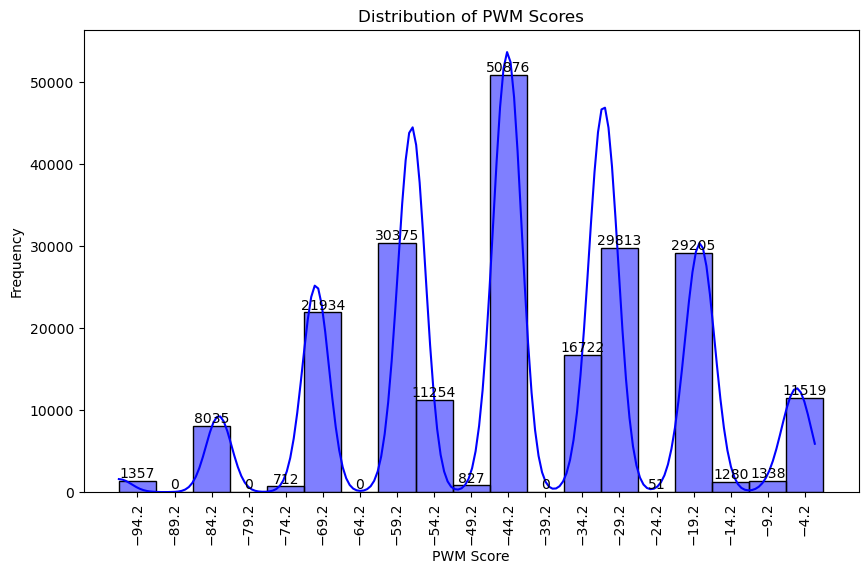

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume unique_tss_df is your DataFrame and PWM_Score is already calculated
# Plotting the distribution of PWM_Score


# Determine the range of PWM scores
min_score = unique_tss_df['PWM_Score'].min()
max_score = unique_tss_df['PWM_Score'].max()

# Create bins from min to max with each bin covering a range of 5 units
bins = np.arange(min_score, max_score + 5, 5)  # +5 in max_score for inclusive range on the upper end

# Calculate the center of each bin for x-ticks
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Plotting the distribution of PWM_Score
plt.figure(figsize=(10, 6))
hist = sns.histplot(unique_tss_df['PWM_Score'], bins=bins, kde=True, color='blue')  # Histogram with specified bins

# Annotate each bin with the count of observations
for p in hist.patches:
    plt.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', 
                 xytext = (0, 5), 
                 textcoords = 'offset points')

# Set x-ticks to the center of each bin
plt.xticks(bin_centers, rotation=90)  # Rotate if labels overlap or for better readability

plt.title('Distribution of PWM Scores')
plt.xlabel('PWM Score')
plt.ylabel('Frequency')
plt.show()

In [72]:
score_threshold = -3  # Placeholder value
# Filter dataframe for sequences predicted to contain a TATA core promoter
unique_tss_df[unique_tss_df['PWM_Score'] > score_threshold]

,Chromosome,50BP_Start,50BP_End,Strand,TSS,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence,PWM_Score,PWM_Position
38,chr1,297502,297602,-,297502,ENSG00000228463.10,transcribed_processed_pseudogene,ENSG00000228463,[nan],OTTHUMG00000002552.3,ENST00000424587.7,processed_transcript,ENST00000424587,ATGTAATAGATATACAATATATAATATATAATAGATATATAATATT...,-2.866522,26
6538,chr1,54036802,54036902,-,54036802,ENSG00000116209.12,protein_coding,TMEM59,HGNC:1239,OTTHUMG00000008437.7,ENST00000470395.1,processed_transcript,TMEM59-209,CCAACCTAATGTAATAGCTATTAGTATAATATTTCCTTCTGTAAGT...,-2.866522,24
7686,chr1,74763843,74763943,+,74763893,ENSG00000162623.16,protein_coding,TYW3,HGNC:24757,OTTHUMG00000009641.6,ENST00000467646.1,processed_transcript,TYW3-204,ATTTCGTTTCAGTACACACAGATATAATAGTAGTACTTATTTCTTC...,-2.866522,22
7727,chr1,75750401,75750501,+,75750451,ENSG00000117054.15,protein_coding,ACADM,HGNC:89,OTTHUMG00000009784.3,ENST00000481374.1,processed_transcript,ACADM-205,GTTTTAAAGATAACATGAACTTTTGCTTTATAATATCTTAAAATAC...,-2.866522,28
7776,chr1,76753085,76753185,+,76753135,ENSG00000199921.1,snRNA,RNU6-161P,HGNC:47124,[nan],ENST00000363051.1,snRNA,RNU6-161P-201,TATTATGCATGATTCTAACACATACAAATATAATATTAAACAAAAT...,-2.866522,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203656,chr9,92292593,92292693,-,92292593,ENSG00000239183.1,snoRNA,SNORA84,HGNC:33615,[nan],ENST00000459229.1,snoRNA,SNORA84-201,CGAAGAGTCAAGGGCCTGGATTATAATAAGAGGGAAGCAAAGGGGA...,-2.866522,21
208388,chrX,19497721,19497821,-,19497721,ENSG00000275800.1,unprocessed_pseudogene,EIF5P2,HGNC:51466,OTTHUMG00000188005.1,ENST00000618904.1,unprocessed_pseudogene,EIF5P2-201,TGTAGTAGTAGTAATCAGAATATAATAAAATATCTCTGCATCTTAT...,-2.866522,20
212642,chrX,129408332,129408432,+,129408382,ENSG00000226339.1,processed_pseudogene,RPS26P56,HGNC:35858,OTTHUMG00000022369.1,ENST00000444468.1,processed_pseudogene,RPS26P56-201,GCACATGTACCCTAAAACTTAAAGTATAATAATAATAAATTTAAAA...,-2.866522,24
215235,chrY,25735160,25735260,-,25735160,ENSG00000232614.1,unprocessed_pseudogene,USP9YP9,HGNC:38435,OTTHUMG00000045258.1,ENST00000429406.1,unprocessed_pseudogene,USP9YP9-201,TCATTTTCTCTATCTAATAAGTTGAGCCTATAATACTTTTTCTTTT...,-2.866522,28


In [71]:
# Your existing function
def find_tata_box(sequence):
    # tata_pattern_plus = r"TAT[AT][AT][AG]"  # Simplified TATA box pattern
    # tata_pattern_minus= r"[TC][AT][AT]ATA"
    tata_pattern = r"TAT[AT][AT][AG]|[TC][AT][AT]ATA"
    for match in re.finditer(tata_pattern, sequence):
        yield match.start()

In [72]:
# Assuming 'unique_tss_df' is your DataFrame with the sequences

# Apply the function to each sequence and store the results in a new column
unique_tss_df['TATA_Box_Positions'] = unique_tss_df['Sequence'].apply(lambda seq: list(find_tata_box(seq)))

In [75]:
# Create the three dataframes based on the conditions
# 1. TATA Core Promoter DataFrame
tata_core_df = unique_tss_df[unique_tss_df['TATA_Box_Positions'].apply(
    lambda positions: any(20 <= pos <= 35 for pos in positions))]

# 2. Sequences containing TATA Box but not functioning as TATA core promoter
tata_non_functional_df = unique_tss_df[unique_tss_df['TATA_Box_Positions'].apply(
    lambda positions: any(pos not in range(20, 36) for pos in positions) if positions else False)]

# 3. DataFrame without TATA Box
no_tata_df = unique_tss_df[unique_tss_df['TATA_Box_Positions'].apply(len) == 0]

In [76]:
tata_core_df

,Chromosome,50BP_Start,50BP_End,Strand,TSS,GeneID,gene_type,gene_name,hgnc_id,havana_gene,transcript_id,transcript_type,transcript_name,Sequence,TATA_Box_Positions
5,chr1,30217,30317,+,30267,ENSG00000243485.5,lncRNA,MIR1302-2HG,HGNC:52482,OTTHUMG00000000959.2,ENST00000469289.1,lncRNA,MIR1302-2HG-201,AAAGAAAGAAAAGAGGCTTTTTTAAAAAGTTAAATATATAAAAAGA...,"[30, 36]"
14,chr1,120932,121032,-,120932,ENSG00000238009.6,lncRNA,ENSG00000238009,[nan],OTTHUMG00000001096.2,ENST00000466430.5,lncRNA,ENST00000466430,AATAGATATACAATATATAATATGTAATAGATATATATTATATATA...,"[13, 31, 38, 51, 58]"
25,chr1,157887,157987,-,157887,ENSG00000222623.1,snRNA,RNU6-1100P,HGNC:48063,[nan],ENST00000410691.1,snRNA,RNU6-1100P-201,TATTTACTGAGCTGTTACTAGGTGCCTATAAATAGCATAGATTTTT...,"[0, 26]"
31,chr1,182646,182746,+,182696,ENSG00000279928.2,unprocessed_pseudogene,DDX11L17,HGNC:55080,OTTHUMG00000191962.1,ENST00000624431.2,unprocessed_pseudogene,DDX11L17-201,CCCCTGTTGTCTGCATGTAACTTAATACCACAACCAGGCATAGGGG...,[21]
38,chr1,297502,297602,-,297502,ENSG00000228463.10,transcribed_processed_pseudogene,ENSG00000228463,[nan],OTTHUMG00000002552.3,ENST00000424587.7,processed_transcript,ENST00000424587,ATGTAATAGATATACAATATATAATATATAATAGATATATAATATT...,"[17, 24, 35, 45, 58]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215174,chrY,24501505,24501605,-,24501505,ENSG00000232003.2,processed_pseudogene,ZNF736P12Y,HGNC:38431,OTTHUMG00000045107.1,ENST00000443152.1,processed_pseudogene,ZNF736P12Y-201,TTGTCACCTTGTTAATGTGCTTTGTGTAACTAATATTTGTAAAATG...,[29]
215182,chrY,24683607,24683707,+,24683657,ENSG00000226270.3,processed_pseudogene,ZNF736P2Y,HGNC:37727,OTTHUMG00000045110.1,ENST00000416040.1,processed_pseudogene,ZNF736P2Y-201,TGAGTCTAATGAGGGAGAGATTTATAGTCCTTTTATTTTCTTAGCT...,[20]
215195,chrY,24978317,24978417,-,24978317,ENSG00000278602.1,unprocessed_pseudogene,ENSG00000278602,[nan],OTTHUMG00000188109.1,ENST00000616864.1,unprocessed_pseudogene,ENST00000616864,AGAAATTTAAAATATCTATAGTAAATAAATGACATTAATTCTGCAT...,[21]
215241,chrY,25904468,25904568,+,25904518,ENSG00000232914.1,unprocessed_pseudogene,TRAPPC2P4,HGNC:10713,OTTHUMG00000045261.1,ENST00000421750.1,unprocessed_pseudogene,TRAPPC2P4-201,AAAAATATGCACTATTTTTTGCTTCATTAGGAGCCATATATTGAAG...,[34]


In [121]:
tata_core_df.to_csv("/data/private/pdutta/DNABERT_data/Core_Prom_new/TATA/raw_positive.tsv", sep="\t", index=False)

In [114]:
# Your existing function
def find_tata_box_stringent(sequence):
    # tata_pattern_plus = r"TAT[AT][AT][AG]"  # Simplified TATA box pattern
    # tata_pattern_minus= r"[TC][AT][AT]ATA"
    tata_pattern = r"TATA[AT][AT][AG]"
    for match in re.finditer(tata_pattern, sequence):
        yield match.start()

In [116]:
# Initialize a list to hold results
results = []
#[f'chr{i}' for i in range(1, 23)] +
# Iterate through specified chromosomes only
for chrom in [f'chr{i}' for i in range(1, 23)]+ ['chrX', 'chrY']:
    sequence = genome[chrom]  # Fetch the sequence for the chromosome
    length = len(sequence)
    print(chrom)
    #print(sequence[0:10])

    # Break down the chromosome into 100 bp segments and search
    for i in range(0, length - 100 + 1, 50):  # 50 bp step for some overlap; adjust as needed
        segment = str(sequence[i:i+100]).upper()  # Ensure segment is a string and uppercase
        #print(segment)
        # Check if segment is a proper string before processing
        if isinstance(segment, str):
            for pos in find_tata_box_stringent(segment):
                if 75 <= pos <= 81:
                    results.append({
                        'Chromosome': chrom,
                        'Start': i,
                        'End': i + 100,
                        'TATA_Box_Position': pos,
                        'Sequence': segment
                    })
        else:
            print(f"Non-string segment detected at {chrom}:{i}-{i+100}")

# Convert results into a DataFrame
tata_box_df = pd.DataFrame(results)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
chrX
chrY


In [117]:
tata_box_df

,Chromosome,Start,End,TATA_Box_Position,Sequence
0,chr1,24300,24400,81,TCTATTGCTTATTTAGGTCTTTCTCTCCTGCCAGAATGTGCGCTCC...
1,chr1,27350,27450,79,ATTGAGATGTGCCATAAGTGTAAAATATGCACCAAATTTCAAAGGC...
2,chr1,43550,43650,78,CCCACAGCTAACATCATAATAGTAAAATCATCACACTGGTAAAAAA...
3,chr1,45650,45750,75,ATGTGTTAATTAACTTGATTTATTCATTCAACAACATACACATATA...
4,chr1,50700,50800,80,AAAATGCCATTATCCAAAGTGGTTCTCTAGAGATGCTGATGTATAT...
...,...,...,...,...,...
459571,chrY,57150100,57150200,79,ACCCCCTTATCTGGCTGTTCATGTGTTTTCTTTACCATGTCCTTTA...
459572,chrY,57151700,57151800,81,TGGGGGGGGCAGTCTGGTGTTACTGAGCCCTTAAACTATTAGGTAT...
459573,chrY,57171600,57171700,76,ACTGACCTTATATTGCTAGTCTTTGCTTTTGTACCTCTTTAGGGCA...
459574,chrY,57174800,57174900,77,ATACCCGTGAGGAAAATGAAGGACTAGCACATTGGGCCTTAATAAA...


In [118]:
# Convert DataFrames to BED format for pybedtools
tata_box_bed = pybedtools.BedTool.from_dataframe(tata_box_df[['Chromosome', 'Start', 'End']])
tata_core_bed = pybedtools.BedTool.from_dataframe(tata_core_df[['Chromosome', '50BP_Start', '50BP_End']])
# Use the intersect function with the -v option to get non-intersecting regions
non_intersecting = tata_box_bed.intersect(tata_core_bed, v=True)

In [119]:
# Convert back to DataFrame
non_intersecting_df = non_intersecting.to_dataframe(names=['Chromosome', 'Start', 'End'])

# You might want to merge back additional information from tata_box_df if needed
tata_box_df_filtered = pd.merge(non_intersecting_df, tata_box_df, on=['Chromosome', 'Start', 'End'])

In [120]:
tata_box_df_filtered

,Chromosome,Start,End,TATA_Box_Position,Sequence
0,chr1,24300,24400,81,TCTATTGCTTATTTAGGTCTTTCTCTCCTGCCAGAATGTGCGCTCC...
1,chr1,27350,27450,79,ATTGAGATGTGCCATAAGTGTAAAATATGCACCAAATTTCAAAGGC...
2,chr1,43550,43650,78,CCCACAGCTAACATCATAATAGTAAAATCATCACACTGGTAAAAAA...
3,chr1,45650,45750,75,ATGTGTTAATTAACTTGATTTATTCATTCAACAACATACACATATA...
4,chr1,50700,50800,80,AAAATGCCATTATCCAAAGTGGTTCTCTAGAGATGCTGATGTATAT...
...,...,...,...,...,...
459193,chrY,57150100,57150200,79,ACCCCCTTATCTGGCTGTTCATGTGTTTTCTTTACCATGTCCTTTA...
459194,chrY,57151700,57151800,81,TGGGGGGGGCAGTCTGGTGTTACTGAGCCCTTAAACTATTAGGTAT...
459195,chrY,57171600,57171700,76,ACTGACCTTATATTGCTAGTCTTTGCTTTTGTACCTCTTTAGGGCA...
459196,chrY,57174800,57174900,77,ATACCCGTGAGGAAAATGAAGGACTAGCACATTGGGCCTTAATAAA...


In [122]:
tata_box_df_filtered.to_csv("/data/private/pdutta/DNABERT_data/Core_Prom_new/TATA/raw_negative_all.tsv", sep="\t", index=False)

In [125]:
tata_box_df_filtered_sample = tata_box_df_filtered.sample(n=8500, random_state=1).reset_index(drop=True)

In [126]:
tata_box_df_filtered_sample

,Chromosome,Start,End,TATA_Box_Position,Sequence
0,chr5,26073800,26073900,76,GACTATACCAAGGCATTTCTACACCTTTCTTTATCATCTGTACATT...
1,chr16,7125250,7125350,75,GTTGTCGTTCAGCCTTTCTAACCTGCAGCATCCTCATTTGTGCAGT...
2,chr8,107362200,107362300,80,TAACAGGCAACGTGCCATGAATACATAAATATGAAAAAGATGCAGT...
3,chr10,123781250,123781350,79,GAGGCAATGTCTGCTCTTCACTTGATTCCCTTCCATATAAATTGAC...
4,chr3,149746400,149746500,78,AGGAGTAGTTTCAGTAGAGAGGGGGTGTATTAGTCCTTTCTCACAC...
...,...,...,...,...,...
8495,chr3,105119050,105119150,79,ACACATAAATATAGTCATCCACTGCCTACGGAAATTTTAGTCAATG...
8496,chr10,10642300,10642400,76,GTCACACCAACCTTCATACTCTCTCTGAATCACTTCTCCAGCACAG...
8497,chr18,1045150,1045250,80,ATACATATATGTAGATTCCATCATATATGGGAACAAAAGTTTCCAT...
8498,chr6,51491650,51491750,79,ACAACATGGGAGAAAGGCAGGCAGAAGCAAGATACCCCATCCACTT...


In [127]:
tata_box_df_filtered_sample.to_csv("/data/private/pdutta/DNABERT_data/Core_Prom_new/TATA/raw_negative.tsv", sep="\t", index=False)

In [8]:
df_pos

,Sequence
0,GCTTTG CTTTGC TTTGCA TTGCAT TGCATG GCATGC CATG...
1,GGACGG GACGGA ACGGAG CGGAGC GGAGCG GAGCGG AGCG...
2,CTCCAC TCCACT CCACTT CACTTC ACTTCC CTTCCT TTCC...
3,TGGCCC GGCCCC GCCCCG CCCCGC CCCGCC CCGCCC CGCC...
4,TCCCTC CCCTCC CCTCCC CTCCCA TCCCAC CCCACC CCAC...
...,...
4320,GTGCGA TGCGAG GCGAGG CGAGGA GAGGAG AGGAGT GGAG...
4321,ATGACA TGACAG GACAGT ACAGTC CAGTCC AGTCCT GTCC...
4322,CGCGGC GCGGCA CGGCAC GGCACA GCACAG CACAGG ACAG...
4323,ATGACA TGACAG GACAGT ACAGTC CAGTCC AGTCCT GTCC...


In [9]:
df_pos['Label']=1

In [10]:
df_pos = df_pos.reset_index(drop=True)
df_pos

,Sequence,Label
0,GCTTTG CTTTGC TTTGCA TTGCAT TGCATG GCATGC CATG...,1
1,GGACGG GACGGA ACGGAG CGGAGC GGAGCG GAGCGG AGCG...,1
2,CTCCAC TCCACT CCACTT CACTTC ACTTCC CTTCCT TTCC...,1
3,TGGCCC GGCCCC GCCCCG CCCCGC CCCGCC CCGCCC CGCC...,1
4,TCCCTC CCCTCC CCTCCC CTCCCA TCCCAC CCCACC CCAC...,1
...,...,...
236970,GTGCGA TGCGAG GCGAGG CGAGGA GAGGAG AGGAGT GGAG...,1
236971,ATGACA TGACAG GACAGT ACAGTC CAGTCC AGTCCT GTCC...,1
236972,CGCGGC GCGGCA CGGCAC GGCACA GCACAG CACAGG ACAG...,1
236973,ATGACA TGACAG GACAGT ACAGTC CAGTCC AGTCCT GTCC...,1


In [12]:
df_pos.to_csv("/data/projects/DNABERT_data/Core_promoters/Core_promoter_regions/positive_set.tsv", sep="\t", index=False)